In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!pip install -q kaggle

In [7]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:08<00:00, 371MB/s]
100% 1.06G/1.06G [00:08<00:00, 135MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.applications.vgg16 import VGG16

In [10]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top=False,
    input_shape=(130,130,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Generators for Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory = '/content/train',
    target_size=(130,130),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    directory = '/content/test',
    target_size=(130,130),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
# # Normalize
# def process(image,label):
#   image=tensorflow.cast(image/255. , tensorflow.float64)
#   return image,label

# train_generator = train_datagen.map(process)
# test_generator = test_datagen.map(process)

In [32]:
conv_base.trainable = False

for layer in conv_base.layers:
  if layer.name[:6] == 'block5':
    layer.trainable = True
  else:
    layer.trainable = False

In [33]:
for layer in conv_base.layers:
  if layer.trainable:
    print(layer.name,'True')
  else:
    print(layer.name,'False')

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# using RMSProp would be better as experimentally proven that
# lower LR should be maintained for better results (lr = le - 5)

In [35]:
history = model.fit(train_generator, epochs=10, validation_data = test_generator)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8336 - loss: 0.5308

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 203ms/step - accuracy: 0.8337 - loss: 0.5305 - val_accuracy: 0.9226 - val_loss: 0.1886
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 197ms/step - accuracy: 0.9060 - loss: 0.2308 - val_accuracy: 0.9230 - val_loss: 0.1823
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.9254 - loss: 0.1701 - val_accuracy: 0.9390 - val_loss: 0.1455
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.9229 - loss: 0.2194 - val_accuracy: 0.9434 - val_loss: 0.1423
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.9469 - loss: 0.1323 - val_accuracy: 0.9472 - val_loss: 0.1341
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.9577 - loss: 0.1077 - val_accuracy: 0.9474 - val_loss: 0.1349
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - accuracy: 0.9617 - loss: 0.0970 - val_accuracy: 0.9452 - val_loss: 0.1482
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.9604 - loss: 0.10

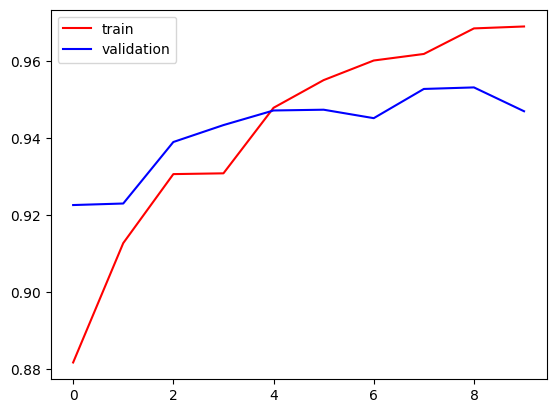

In [37]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

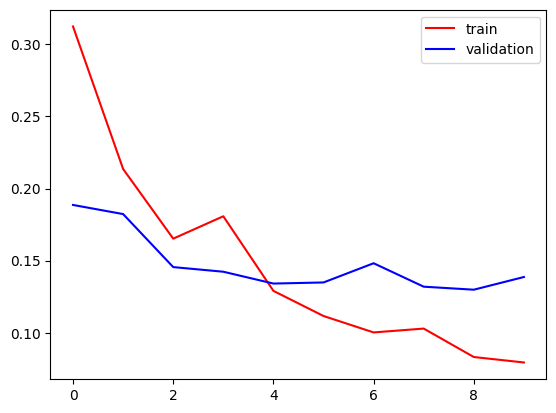

In [38]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()